# 1) Setup and connection

In [1]:
# Python Version
from platform import python_version
print("Python", python_version())

Python 3.12.2


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates
from google.cloud import bigquery
import os

plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 12

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r"meu_projeto.json"
client = bigquery.Client()
PROJECT_ID = "bigquery-public-data"
DATASET_ID = "chicago_taxi_trips"
TABLE_ID = "taxi_trips"
FULL_TABLE = f"{PROJECT_ID}.{DATASET_ID}.{TABLE_ID }"

print("Project:", PROJECT_ID)
print("Dataset:", DATASET_ID)
print("Table", TABLE_ID)
print("Setup Complete")

Project: bigquery-public-data
Dataset: chicago_taxi_trips
Table taxi_trips
Setup Complete


# 2) Initial exploration

In [3]:
# List available tables in the dataset
dataset_ref = client.dataset(DATASET_ID, project=PROJECT_ID)
dataset =client.get_dataset(dataset_ref)
tables = list(client.list_tables(dataset))
print("tables in dataset")
for t in tables:
    print("-", t.table_id)

tables in dataset
- taxi_trips


In [4]:
# View columns (schema) of the main table
table_ref = dataset_ref.table(TABLE_ID)
table = client.get_table(table_ref)
schema = [(f.name, f.field_type, f.mode) for f in table.schema]
pd.DataFrame(schema, columns=["column_name","type", "mode"])

,column_name,type,mode
0,unique_key,STRING,REQUIRED
1,taxi_id,STRING,REQUIRED
2,trip_start_timestamp,TIMESTAMP,NULLABLE
3,trip_end_timestamp,TIMESTAMP,NULLABLE
4,trip_seconds,INTEGER,NULLABLE
5,trip_miles,FLOAT,NULLABLE
6,pickup_census_tract,INTEGER,NULLABLE
7,dropoff_census_tract,INTEGER,NULLABLE
8,pickup_community_area,INTEGER,NULLABLE
9,dropoff_community_area,INTEGER,NULLABLE


In [5]:
# Sample data (5 lines)
sample_df = client.list_rows(table, max_results=5).to_dataframe()
sample_df


,unique_key,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,...,extras,trip_total,payment_type,company,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location
0,7dfc5e435eebecdcff5c5e34743c8eb5e5f9bc71,6e24d43a7ccff7c16428c8997b99ed9c15dccb81f85f4c...,2015-08-17 23:00:00+00:00,2015-08-17 23:00:00+00:00,0,0.00,<NA>,<NA>,<NA>,<NA>,...,NaN,NaN,Credit Card,None,NaN,NaN,None,NaN,NaN,None
1,ddfe58f156b3ce48100cc1997b2b7cb217640628,6e24d43a7ccff7c16428c8997b99ed9c15dccb81f85f4c...,2015-08-17 23:00:00+00:00,2015-08-17 23:00:00+00:00,60,0.00,<NA>,<NA>,<NA>,<NA>,...,NaN,NaN,Credit Card,None,NaN,NaN,None,NaN,NaN,None
2,30544de3182e5183eb98f34686d054f0e14d09b2,209204ff3fb18a2e31603ef9cf6d4c0fa21d5dddd332a4...,2015-09-16 18:00:00+00:00,2015-09-16 18:00:00+00:00,360,1.80,<NA>,<NA>,<NA>,<NA>,...,NaN,NaN,Credit Card,None,NaN,NaN,None,NaN,NaN,None
3,7a9e0c07ddc65110cd90ccbfc3d3c2cb54ebd86e,e4318a8db4098de8acda060ba7fe7ef05c240a1c81de3f...,2015-09-04 15:30:00+00:00,2015-09-04 15:45:00+00:00,900,3.30,<NA>,<NA>,<NA>,<NA>,...,NaN,NaN,Credit Card,None,NaN,NaN,None,NaN,NaN,None
4,be984c2c2c472d4363da100d9ca864f341a5f333,218100bdb8cbbbde4b4edf363cf5890c6bb7e3cb749f7f...,2015-09-08 10:30:00+00:00,2015-09-08 10:30:00+00:00,0,0.93,<NA>,17031081401,<NA>,8,...,NaN,NaN,Credit Card,None,NaN,NaN,None,41.895033,-87.619711,POINT (-87.6197106717 41.8950334495)


### Auxiliary function for queries

In [6]:
SAFE_BYTES = 20 * 10**9
def run_query(sql: str, maximum_bytes_billed: int = SAFE_BYTES) -> pd.DataFrame:
    job_config = bigquery.QueryJobConfig(maximum_bytes_billed=maximum_bytes_billed)
    job = client.query(sql, job_config=job_config)
    return job.to_dataframe()
    

# 3) Main analyses


## 3.1) Number of trips per year

In [7]:
query_trips_per_year = f"""
                SELECT
                    EXTRACT(YEAR FROM  trip_start_timestamp) AS year,
                    COUNT(*) AS num_trips
                FROM `{FULL_TABLE}`
                GROUP BY year
                ORDER BY year
                """
trips_per_year = run_query(query_trips_per_year)
trips_per_year.head()

,year,num_trips
0,2013,27217300
1,2014,37395079
2,2015,32385527
3,2016,31756403
4,2017,24979611


## 3.2) Trips per month (selected year)

In [8]:
YEAR_FILTER = 2019
query_trips_per_month =f"""
                SELECT
                    EXTRACT(MONTH FROM  trip_start_timestamp) AS month,
                    COUNT(*) AS num_trips
                FROM `{FULL_TABLE}`
                WHERE EXTRACT(YEAR FROM trip_start_timestamp) = {YEAR_FILTER}
                GROUP BY month
                ORDER BY month
                """
trips_per_month = run_query(query_trips_per_month)
trips_per_month

,month,num_trips
0,1,1213500
1,2,1312757
2,3,1515751
3,4,1458320
4,5,1532311
5,6,1491235
6,7,1319048
7,8,1344301
8,9,1335454
9,10,1449378


## 3.3) Trips by time of day and average speed (mph) — Jan–Mar(2019)

In [9]:
query_trips_per_hour = f"""
                WITH relevant AS (
                    SELECT trip_start_timestamp, trip_seconds, trip_miles
                    FROM `{FULL_TABLE}`
                    WHERE trip_start_timestamp  >= '2019-01-01'
                        AND trip_start_timestamp < '2019-04-01'
                        AND trip_seconds > 0
                        AND trip_miles > 0
                )
                SELECT 
                    EXTRACT(HOUR FROM trip_start_timestamp) AS hour_of_day,
                    COUNT(*) AS num_trips,
                    3600 * SUM(trip_miles) / SUM(trip_seconds) AS avg_mph
                    FROM relevant
                    GROUP BY hour_of_day
                    ORDER BY hour_of_day
                    """
trips_per_hour = run_query(query_trips_per_hour)
trips_per_hour.head()
                    
        

,hour_of_day,num_trips,avg_mph
0,0,76120,20.376318
1,1,61847,18.726146
2,2,48651,17.464499
3,3,39293,17.846080
4,4,29577,22.971773


## 3.4) Top 10 destination areas (2019)

In [10]:
YEAR_FILTER = 2019
query_top_destinations = f"""
                SELECT
                    dropoff_community_area AS dropoff_area,
                    COUNT(*) AS num_trips
                   FROM `{FULL_TABLE}`
                WHERE 
                    EXTRACT(YEAR FROM trip_start_timestamp){YEAR_FILTER}
                    AND dropoff_community_area IS NOT NULL
                GROUP BY dropoff_community_area
                ORDER BY num_trips DESC
                LIMIT 10
                """
trips_per_month = run_query(query_trips_per_month)
trips_per_month.head()

,month,num_trips
0,1,1213500
1,2,1312757
2,3,1515751
3,4,1458320
4,5,1532311


## 3.5) Total revenue per year (fare + tips + tools)

In [11]:
query_total_revenue_per_year = f"""
                SELECT 
                    EXTRACT(YEAR FROM trip_start_timestamp) AS year,
                    SUM(COALESCE(fare,0) + COALESCE(tips,0) + COALESCE(tolls, 0)) AS total_revenue
                FROM `{FULL_TABLE}`
                GROUP BY year
                ORDER BY total_revenue DESC
                """
total_revenue_per_year = run_query(query_total_revenue_per_year)
total_revenue_per_year['total_revenue'] = pd.to_numeric(
    total_revenue_per_year['total_revenue'].astype(str).str.replace(',' , '.'),
    errors='coerce' )
total_revenue_per_year = total_revenue_per_year.sort_values('year')
pd.options.display.float_format = '{:,.0f}'.format
total_revenue_per_year.head()


,year,total_revenue
4,2013,"365,279,369"
0,2014,"497,883,418"
2,2015,"451,909,603"
1,2016,"477,089,897"
3,2017,"370,847,804"


## 3.6) Middle distance and longer runs

In [12]:
query_avg_distances = f"""
                    SELECT
                        MIN(NULLIF(trip_miles, 0)) AS min_miles,
                        AVG(NULLIF(trip_miles, 0)) AS avg_miles,
                        MAX(NULLIF(trip_miles, 0)) AS max_miles
                    FROM `{FULL_TABLE}`
                    """
avg_distances = run_query(query_avg_distances)
avg_distances

,min_miles,avg_miles,max_miles
0,0,4,"3,460"


In [13]:
query_longest_runs = f"""
                    SELECT 
                        trip_start_timestamp,
                        trip_end_timestamp
                        trip_miles,
                        trip_seconds,
                        fare,tips,tolls,
                    FROM `{FULL_TABLE}`
                    WHERE trip_miles IS NOT NULL
                    ORDER BY trip_miles DESC
                    LIMIT 5
                    """
query_longest_runs = run_query(query_longest_runs)
query_longest_runs


,trip_start_timestamp,trip_miles,trip_seconds,fare,tips,tolls
0,2023-12-31 19:00:00+00:00,2024-01-02 13:00:00+00:00,<NA>,183,0,0
1,2023-12-30 17:00:00+00:00,2024-01-02 10:15:00+00:00,<NA>,36,0,0
2,2023-12-31 20:15:00+00:00,2024-01-01 15:15:00+00:00,68308,30,0,0
3,2023-12-31 15:00:00+00:00,2024-01-01 13:30:00+00:00,81062,34,8,0
4,2023-12-31 15:00:00+00:00,2024-01-01 13:00:00+00:00,79850,6,1,0


## 3.7) Middle distance and lower runs

In [14]:
query_lowest_number_of_races =  f"""
                    SELECT 
                        pickup_community_area AS area,
                        COUNT(*) AS num_pickups,
                        COUNT(*) * 100.0 / SUM(COUNT(*)) OVER() AS percentage
                        FROM `{FULL_TABLE}`
                        WHERE pickup_community_area IS NOT NULL
                        GROUP BY pickup_community_area
                        ORDER BY num_pickups ASC 
                        LIMIT 10
                        """

lowest_number_of_races = run_query(query_lowest_number_of_races)
lowest_number_of_races.head()      

,area,num_pickups,percentage
0,74,5274,0
1,55,11963,0
2,9,13742,0
3,52,14210,0
4,63,14999,0


## 3.8) Trips per hour

In [15]:
query_trips_per_hour = f"""
                SELECT
                    EXTRACT(HOUR FROM trip_start_timestamp) AS hour,
                    COUNT(*) AS num_trips
                FROM `{FULL_TABLE}`
                WHERE trip_start_timestamp IS NOT NULL
                GROUP BY hour
                ORDER BY hour
                """
query_trips_per_hour = run_query(query_trips_per_hour)
query_trips_per_hour.head()

,hour,num_trips
0,0,7012082
1,1,5792322
2,2,4571459
3,3,3410900
4,4,2471575


In [16]:
query_rush_hour_per_month = f"""
                    SELECT
                        EXTRACT(MONTH FROM trip_start_timestamp) AS month,
                        COUNT(*) AS num_trips,
                        COUNT(CASE WHEN EXTRACT(HOUR FROM trip_start_timestamp) BETWEEN 7 AND 9 THEN 1 END) AS morning_rush,
                        COUNT(CASE WHEN EXTRACT(HOUR FROM trip_start_timestamp) BETWEEN 17 AND 19 THEN 1 END) AS evening_rush
                    FROM `{FULL_TABLE}`
                    WHERE trip_start_timestamp IS NOT NULL
                    GROUP BY month
                    ORDER BY month     
            """

rush_hour_per_month = run_query(query_rush_hour_per_month)
rush_hour_per_month.head()

,month,num_trips,morning_rush,evening_rush
0,1,15988857,1931569,3135691
1,2,16494338,1997560,3281134
2,3,18927609,2236617,3691345
3,4,17751333,2110843,3373067
4,5,18947867,2167159,3536142


## proportionality between the fare and the distance traveled (trip_miles)

In [17]:
query_proportionality = f"""
                        SELECT
                            trip_miles,
                            fare,
                            (fare / trip_miles) AS fare_per_mile,
                                CASE
                                    WHEN(fare / trip_miles) > 10 THEN 'Above average'
                                    WHEN(fare / trip_miles) BETWEEN 5 AND 10 THEN 'Proportional'
                                    ELSE 'Below average'
                             END AS proportionality
                        FROM `{FULL_TABLE}`
                        WHERE trip_miles > 10
                            AND fare IS NOT NULL
                            AND trip_miles IS NOT NULL
                        ORDER BY trip_miles DESC
                        LIMIT 10
                        """
proportionality = run_query(query_proportionality)
proportionality.head()

,trip_miles,fare,fare_per_mile,proportionality
0,"3,460",67,0,Below average
1,"3,431",31,0,Below average
2,"3,400",66,0,Below average
3,"3,390",21,0,Below average
4,"3,370",65,0,Below average


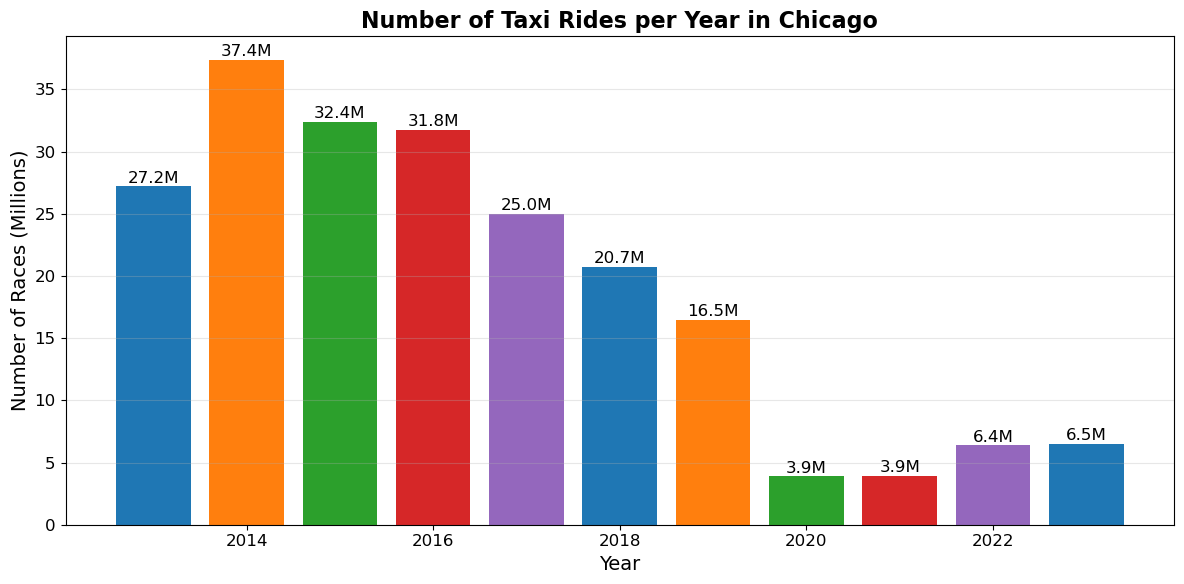

In [18]:
# Bar chart for number of races per year
plt.figure(figsize=(12, 6))
bars = plt.bar(trips_per_year['year'], trips_per_year['num_trips']/1e6, 
               color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])

plt.title('Number of Taxi Rides per Year in Chicago', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Races (Millions)', fontsize=14)
plt.grid(axis='y', alpha=0.3)

# Add values ​​to bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.05,
             f'{height:.1f}M', ha='center', va='bottom')

plt.tight_layout()
plt.show()

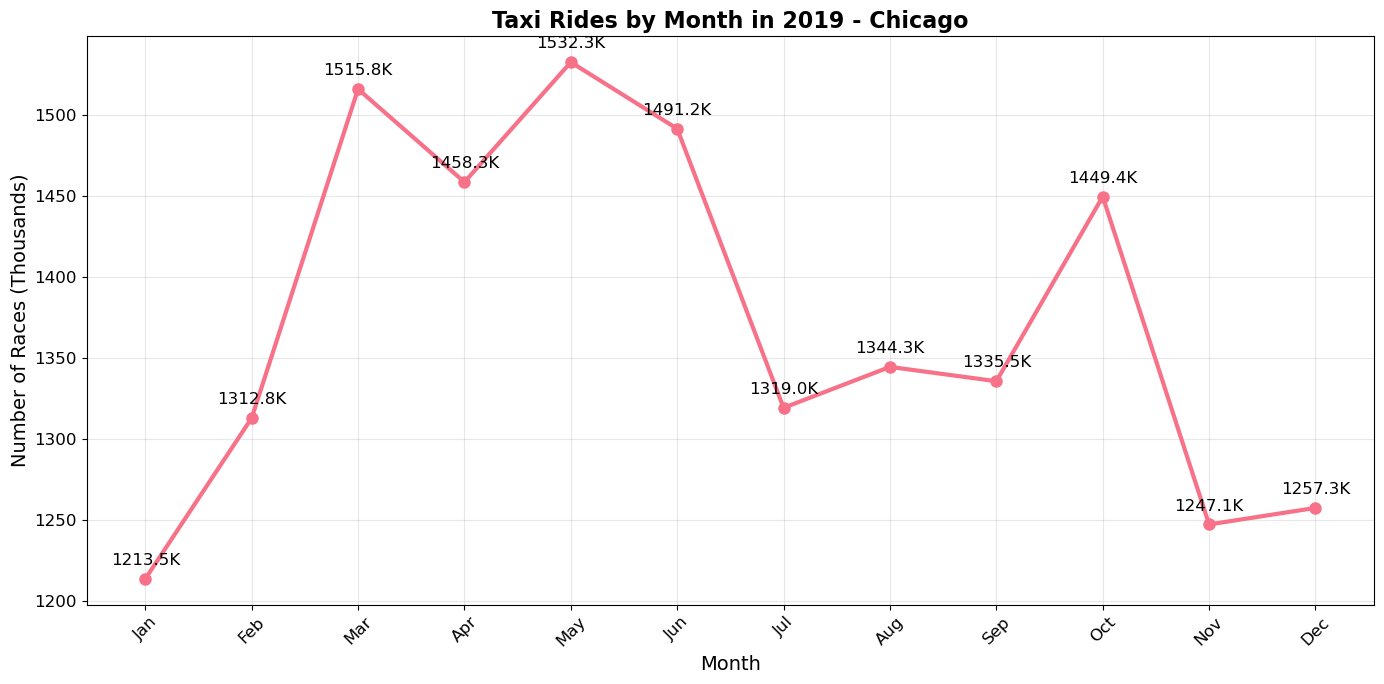

In [19]:
# Line graph for runs by month in 2019
plt.figure(figsize=(14, 7))
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.plot(months, trips_per_month['num_trips']/1e3, marker='o', linewidth=3, markersize=8)

plt.title('Taxi Rides by Month in 2019 - Chicago', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of Races (Thousands)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Add values ​​to points
for i, value in enumerate(trips_per_month['num_trips']/1e3):
    plt.annotate(f'{value:.1f}K', (i, value), textcoords="offset points", 
                 xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()

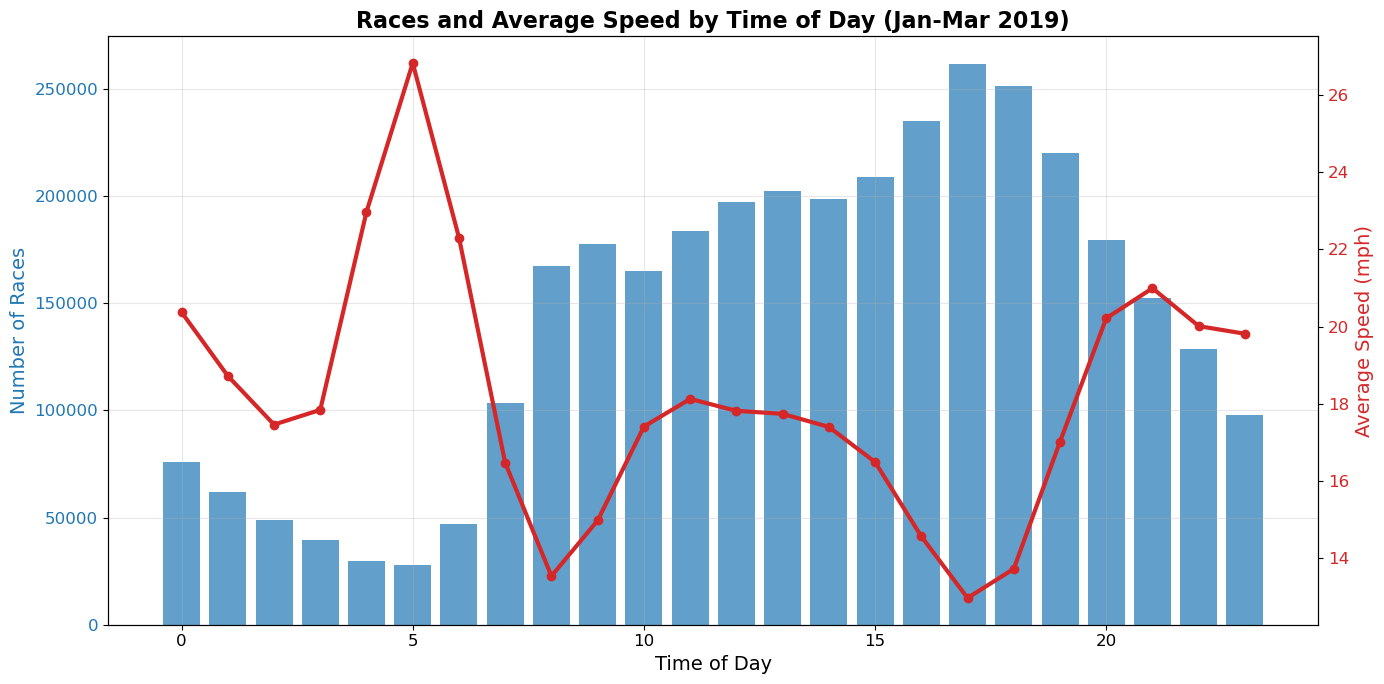

In [20]:
# Dual axis graph for runs and average speed
fig, ax1 = plt.subplots(figsize=(14, 7))

# First axis - number of races
color = 'tab:blue'
ax1.set_xlabel('Time of Day', fontsize=14)
ax1.set_ylabel('Number of Races', fontsize=14, color=color)
bars = ax1.bar(trips_per_hour['hour_of_day'], trips_per_hour['num_trips'], 
alpha=0.7, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

# Second axis - average speed
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Average Speed (mph)', fontsize=14, color=color)
line = ax2.plot(trips_per_hour['hour_of_day'], trips_per_hour['avg_mph'], 
color=color, linewidth=3, marker='o', markersize=6)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Races and Average Speed ​​by Time of Day (Jan-Mar 2019)', 
fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

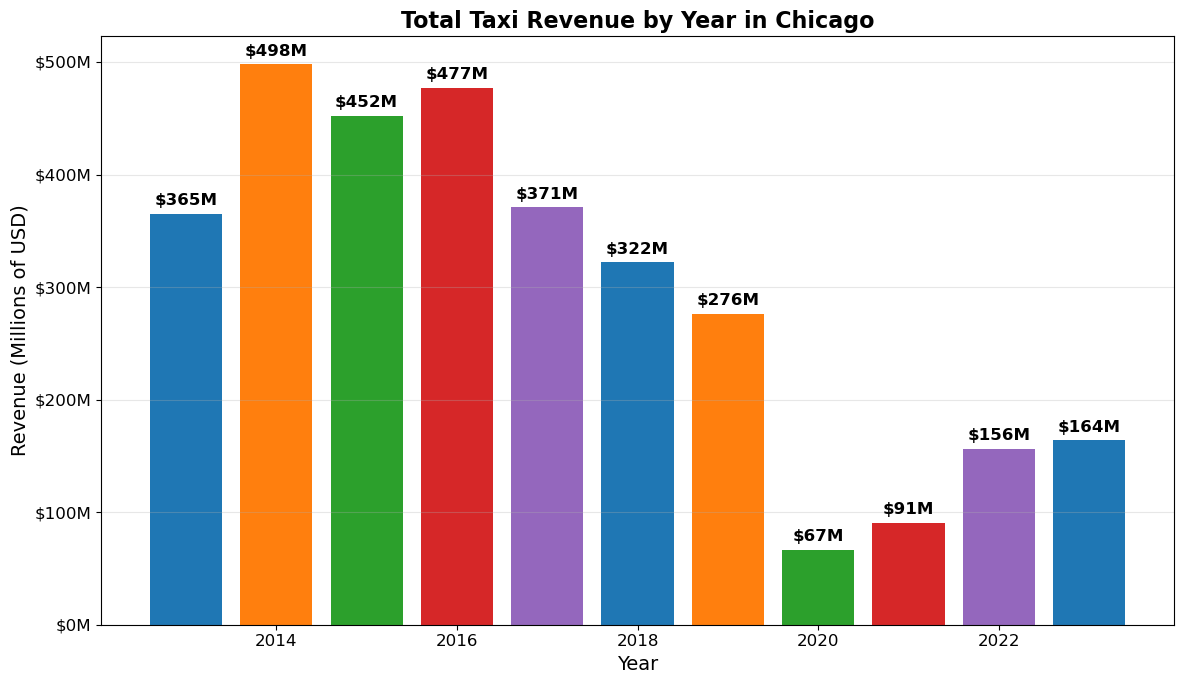

In [21]:
# Bar chart for annual revenue
plt.figure(figsize=(12, 7))
bars = plt.bar(total_revenue_per_year['year'], total_revenue_per_year['total_revenue']/1e6,
color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])

plt.title('Total Taxi Revenue by Year in Chicago', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Revenue (Millions of USD)', fontsize=14)
plt.grid(axis='y', alpha=0.3)

# Format values ​​on the axis Y
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'${x:.0f}M'))

# Add values ​​to bars
for bar in bars: 
    height = bar.get_height() 
    plt.text(bar.get_x() + bar.get_width()/2., height + 5, 
             f'${height:.0f}M', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

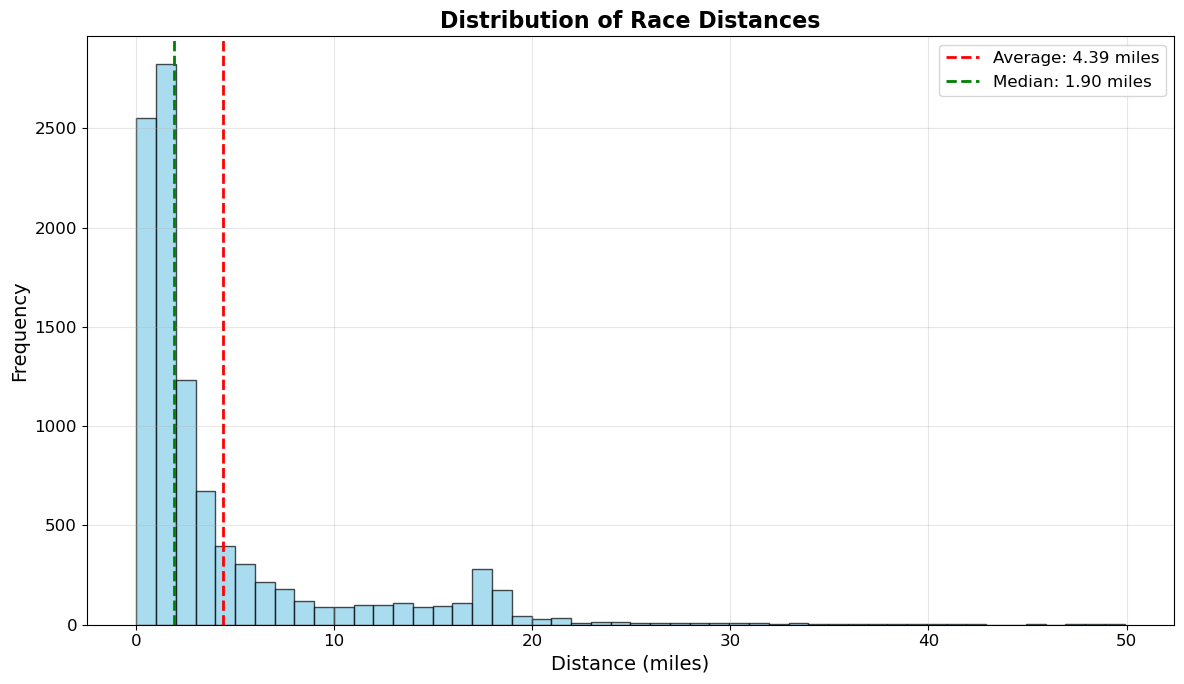

In [22]:
# box plot for the distances
query_distance_sample = f"""
SELECT trip_miles
FROM `{FULL_TABLE}`
WHERE trip_miles > 0 AND trip_miles < 50 # Filter out outliers
LIMIT 10000
"""
distance_sample = run_query(query_distance_sample)

plt.figure(figsize=(12, 7))
plt.hist(distance_sample['trip_miles'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')

plt.title('Distribution of Race Distances', fontsize=16, fontweight='bold')
plt.xlabel('Distance (miles)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(alpha=0.3)

# Add mean and median lines
mean_distance = distance_sample['trip_miles'].mean()
median_distance = distance_sample['trip_miles'].median()

plt.axvline(mean_distance, color='red', linestyle='--', linewidth=2, label=f'Average: {mean_distance:.2f} miles')
plt.axvline(median_distance, color='green', linestyle='--', linewidth=2, label=f'Median: {median_distance:.2f} miles')

plt.legend()
plt.tight_layout()
plt.show()


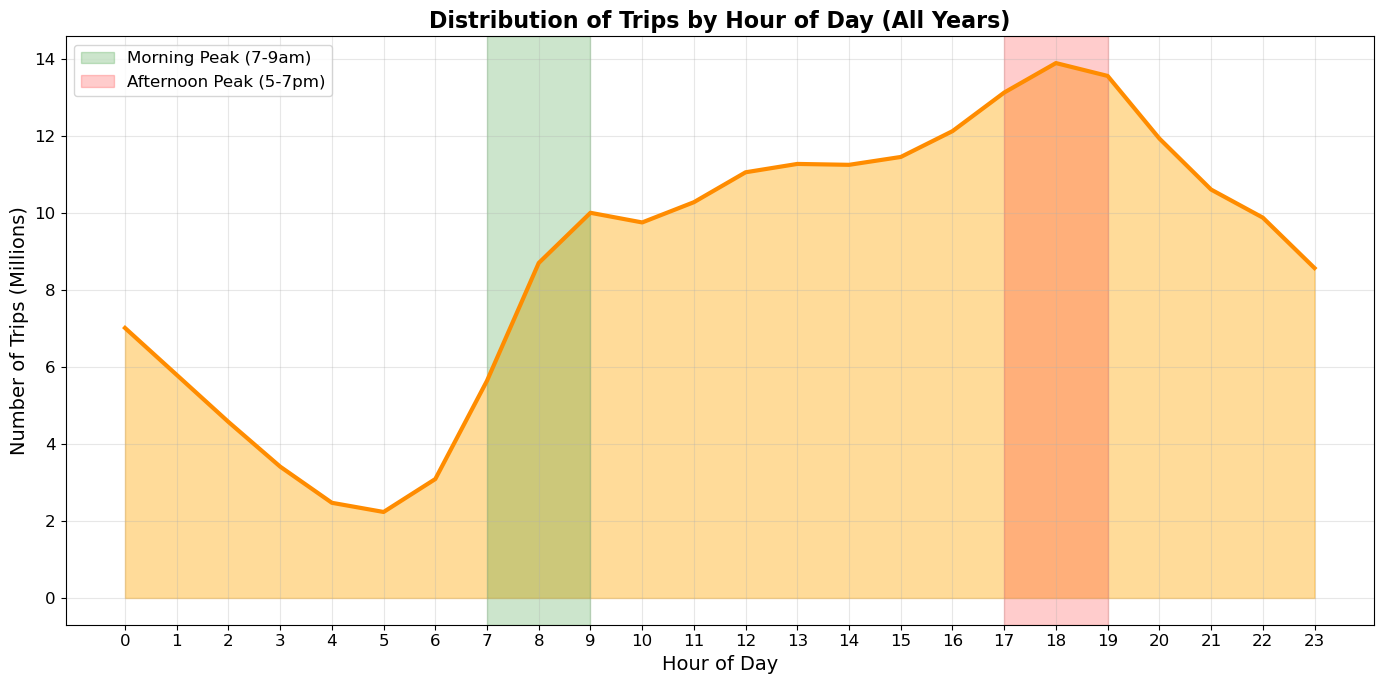

In [23]:
# Area chart for trips per hour
plt.figure(figsize=(14, 7))
plt.fill_between(query_trips_per_hour['hour'], query_trips_per_hour['num_trips']/1e6,
alpha=0.4, color='orange')
plt.plot(query_trips_per_hour['hour'], query_trips_per_hour['num_trips']/1e6,
linewidth=3, color='darkorange')

plt.title('Distribution of Trips by Hour of Day (All Years)', fontsize=16, fontweight='bold')
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Number of Trips (Millions)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 24))

# Highlight peak times
plt.axvspan(7, 9, alpha=0.2, color='green', label='Morning Peak (7-9am)')
plt.axvspan(17, 19, alpha=0.2, color='red', label='Afternoon Peak (5-7pm)')

plt.legend()
plt.tight_layout()
plt.show()

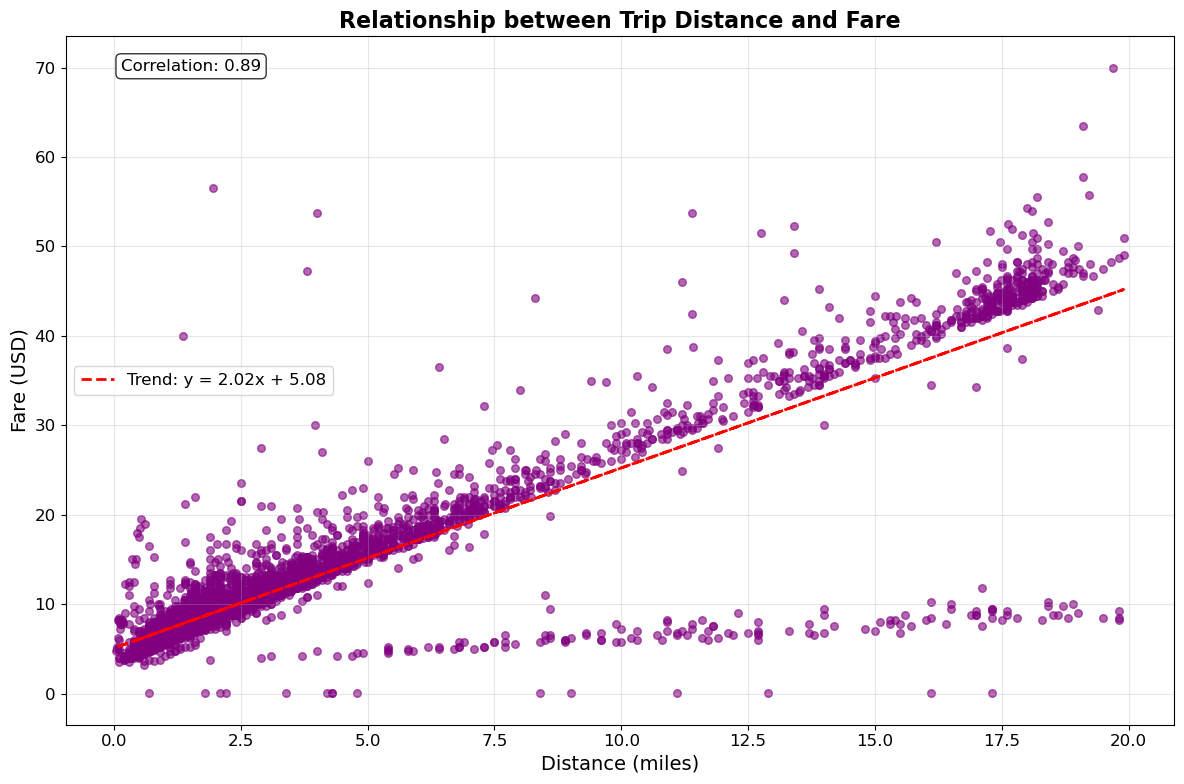

In [24]:
#visualize the relationship
query_fare_distance = f"""
SELECT fare, trip_miles
FROM `{FULL_TABLE}`
WHERE fare > 0 AND fare < 100
AND trip_miles > 0 AND trip_miles < 20
AND trip_seconds > 60
LIMIT 5000
"""
fare_distance = run_query(query_fare_distance)

plt.figure(figsize=(12, 8))
plt.scatter(fare_distance['trip_miles'], fare_distance['fare'],
            alpha=0.6, s=30, color='purple')

# Add trendline
z = np.polyfit(fare_distance['trip_miles'], fare_distance['fare'], 1)
p = np.poly1d(z)
plt.plot(fare_distance['trip_miles'], p(fare_distance['trip_miles']),
         "r--", linewidth=2, label=f'Trend: y = {z[0]:.2f}x + {z[1]:.2f}')

plt.title('Relationship between Trip Distance and Fare', fontsize=16, fontweight='bold')
plt.xlabel('Distance (miles)', fontsize=14)
plt.ylabel('Fare (USD)', fontsize=14)
plt.grid(True, alpha=0.3)

# Calculate and display correlation
correlation = fare_distance['trip_miles'].corr(fare_distance['fare'])
plt.text(0.05, 0.95, f'Correlation: {correlation:.2f}', transform=plt.gca().transAxes, 
         fontsize=12, bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

plt.legend()
plt.tight_layout()
plt.show()

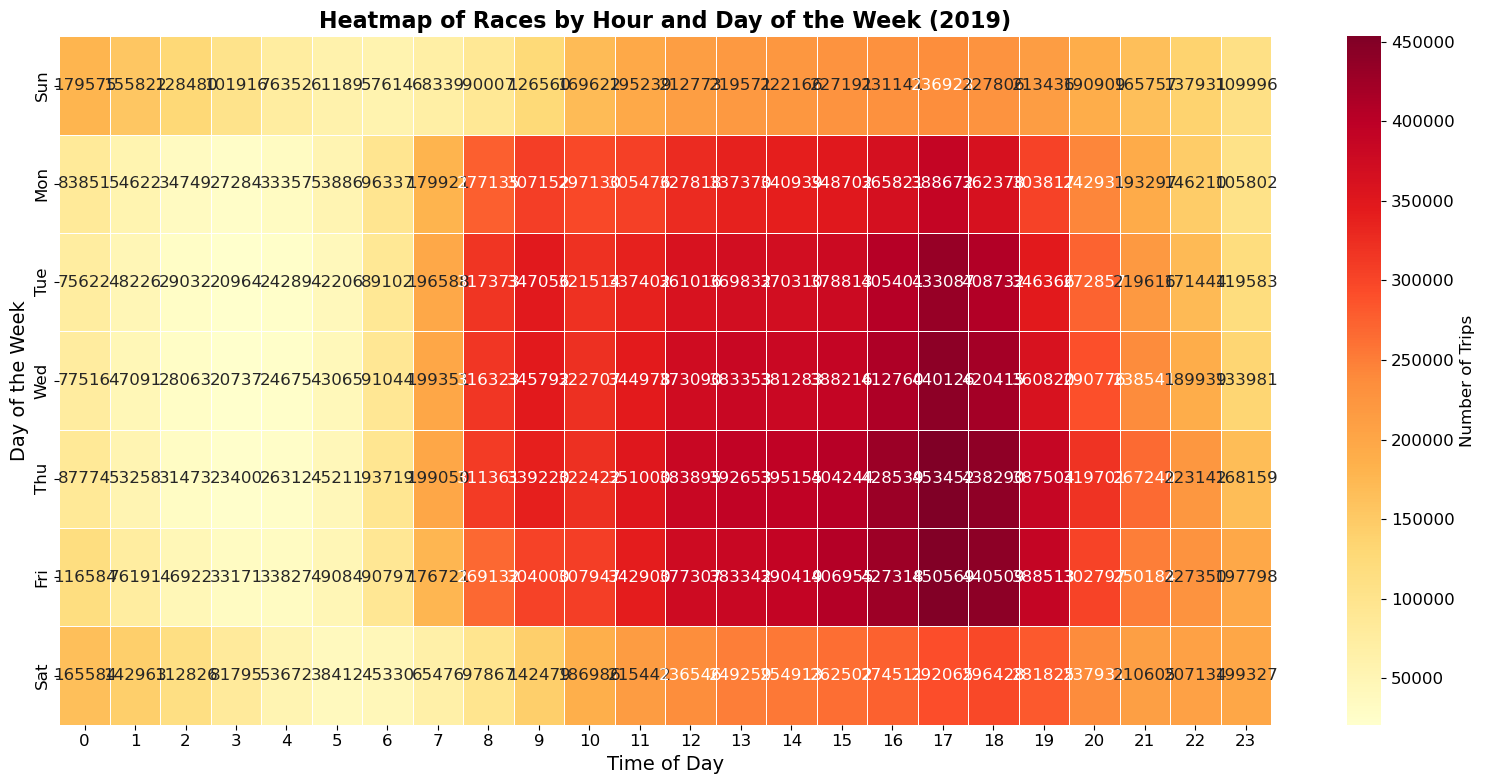

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Query to obtain time and day of the week data

query_hour_weekday = f""" 
        SELECT 
            EXTRACT(HOUR FROM trip_start_timestamp) AS hour, 
            EXTRACT(DAYOFWEEK FROM trip_start_timestamp) AS weekday, 
            COUNT(*) as num_trips 
        FROM `{FULL_TABLE}` 
        WHERE trip_start_timestamp >= '2019-01-01' 
        GROUP BY hour, weekday 
        ORDER BY weekday, hour
        """
hour_weekday = run_query(query_hour_weekday)

hour_weekday["num_trips"] = pd.to_numeric(hour_weekday["num_trips"], errors='coerce')

# Prepare data for heatmap
heatmap_data = hour_weekday.pivot(index='weekday', columns='hour', values='num_trips')

heatmap_data = heatmap_data.fillna(0).astype(float)

# Names of the days of the week
weekday_names = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']

plt.figure(figsize=(16, 8))
sns.heatmap(
    heatmap_data, 
    cmap='YlOrRd',
    xticklabels=range(24),
    yticklabels=weekday_names,
    annot=True,
    fmt=".0f",
    linewidths=0.5,
    cbar_kws={"label": "Number of Trips"}
)

plt.title('Heatmap of Races by Hour and Day of the Week (2019)', fontsize=16, fontweight='bold')
plt.xlabel('Time of Day', fontsize=14)
plt.ylabel('Day of the Week', fontsize=14)
plt.tight_layout()
plt.show()           
                

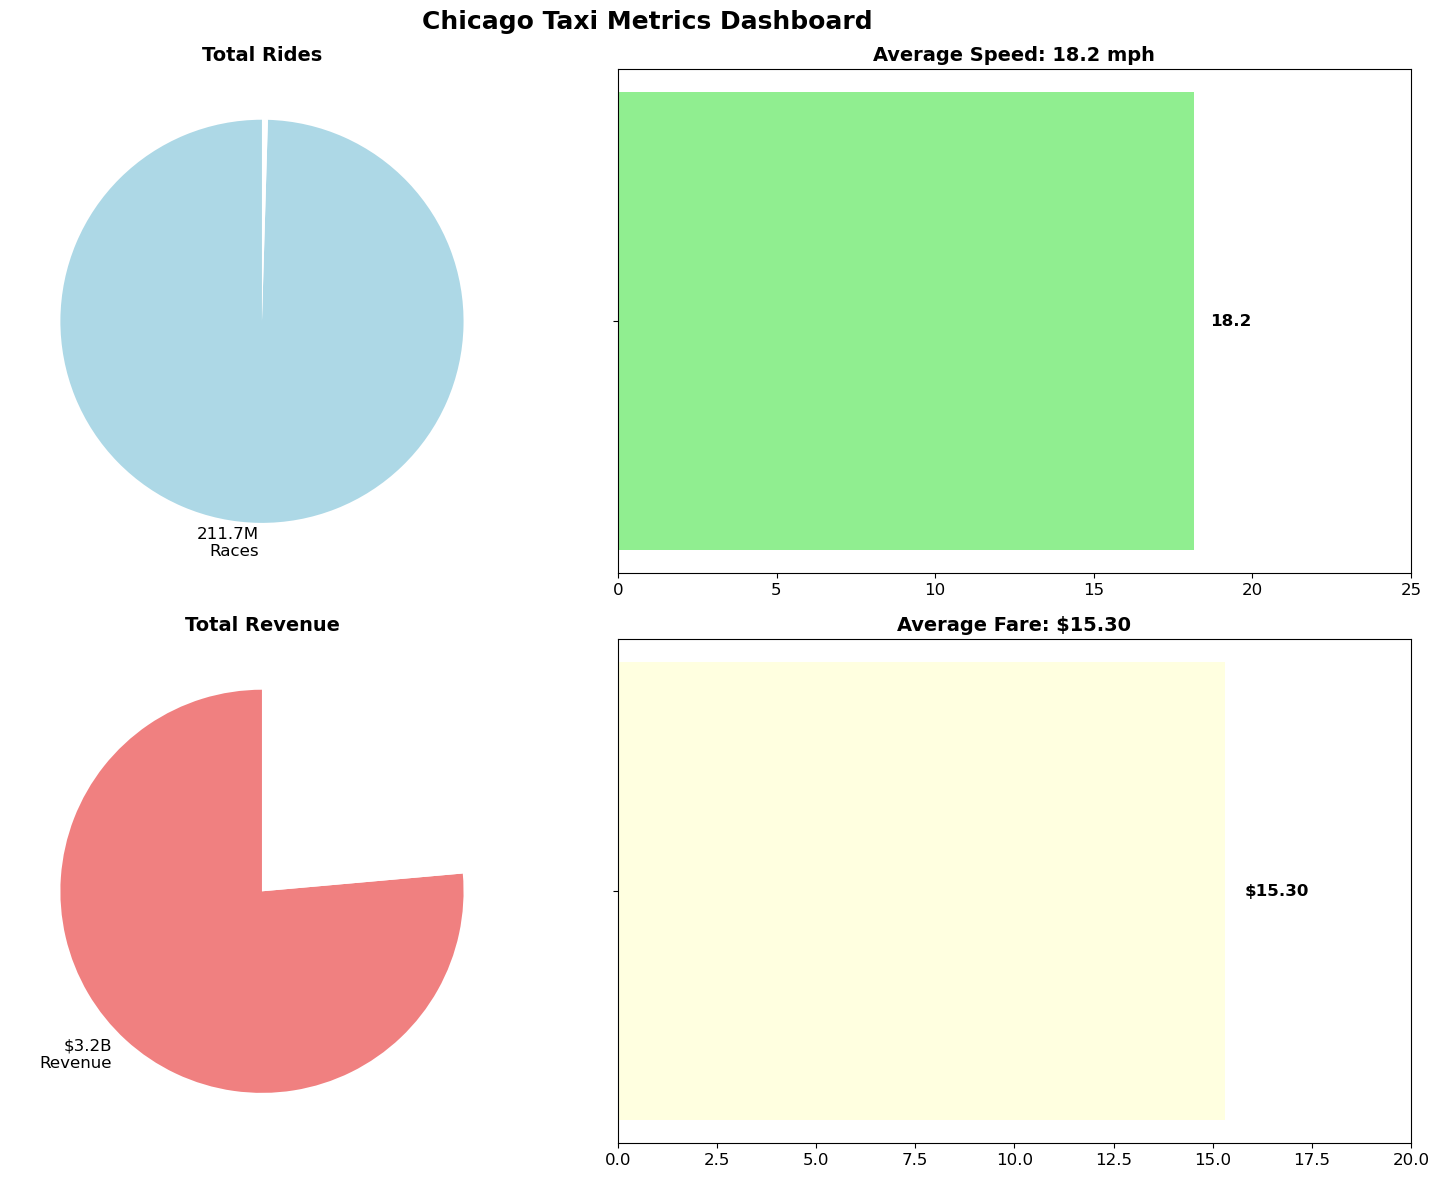

In [26]:
# Calculate summary metrics
total_trips = trips_per_year['num_trips'].sum()
avg_speed = trips_per_hour['avg_mph'].mean()
total_revenue = total_revenue_per_year['total_revenue'].sum()
avg_fare_per_trip = total_revenue / total_trips

# Create dashboard
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

#Metric 1: Total runs
ax1.pie([total_trips/1e6, 1], labels=[f'{total_trips/1e6:.1f}M\nRaces', ''],
        colors=['lightblue', 'white'], startangle=90)
ax1.set_title('Total Rides', fontsize=14, fontweight='bold')

# Metric 2: Average Speed
ax2.barh([''], [avg_speed], color='lightgreen')
ax2.set_xlim(0, 25)
ax2.set_title(f'Average Speed: {avg_speed:.1f} mph', fontsize=14, fontweight='bold')
ax2.text(avg_speed + 0.5, 0, f'{avg_speed:.1f}', va='center', fontweight='bold')

# Metric 3: Total Revenue
ax3.pie([total_revenue/1e9, 1], labels=[f'${total_revenue/1e9:.1f}B\nRevenue', ''],
        colors=['lightcoral', 'white'], startangle=90)
ax3.set_title('Total Revenue', fontsize=14, fontweight='bold')

# Metric 4: Average Fare
ax4.barh([''], [avg_fare_per_trip], color='lightyellow')
ax4.set_xlim(0, 20)
ax4.set_title(f'Average Fare: ${avg_fare_per_trip:.2f}', fontsize=14, fontweight='bold')
ax4.text(avg_fare_per_trip + 0.5, 0, f'${avg_fare_per_trip:.2f}', va='center', fontweight='bold')

plt.suptitle('Chicago Taxi Metrics Dashboard', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

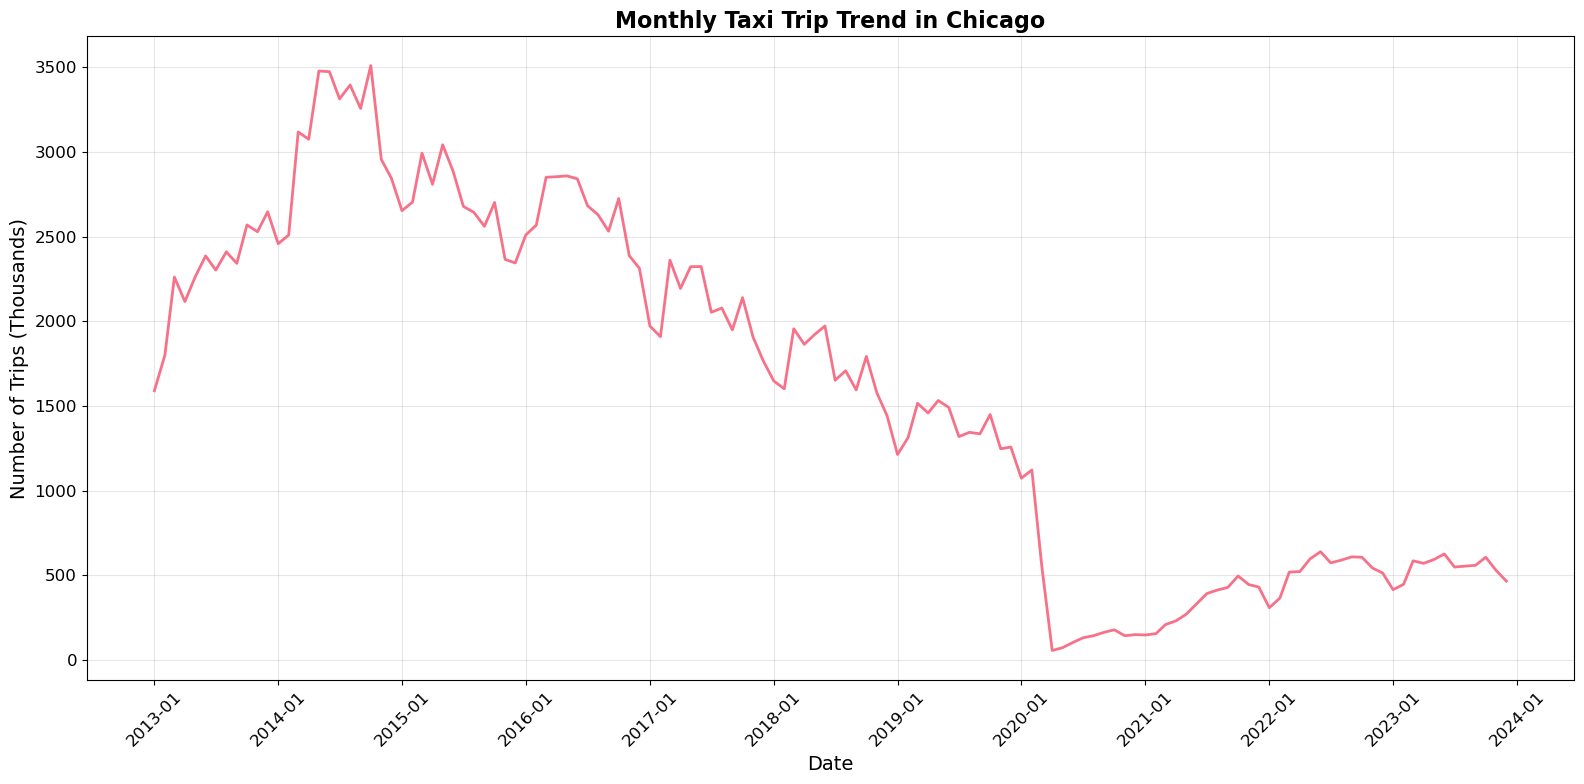

In [27]:
# Query for monthly data over the years
query_monthly_trend = f""" 
    SELECT 
        EXTRACT(YEAR FROM trip_start_timestamp) AS year, 
        EXTRACT(MONTH FROM trip_start_timestamp) AS month, 
        COUNT(*) as num_trips 
    FROM `{FULL_TABLE}` 
    WHERE trip_start_timestamp IS NOT NULL 
    GROUP BY year, month 
    ORDER BY year, month
"""
monthly_trend = run_query(query_monthly_trend)

# Create date column
monthly_trend['date'] = pd.to_datetime(monthly_trend['year'].astype(str) + '-' + 
monthly_trend['month'].astype(str) + '-01')

plt.figure(figsize=(16, 8))
plt.plot(monthly_trend['date'], monthly_trend['num_trips']/1e3, linewidth=2)

plt.title('Monthly Taxi Trip Trend in Chicago', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Trips (Thousands)', fontsize=14)
plt.grid(True, alpha=0.3)

# Format x-axis to display years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()